# Linked trajectories

In order to compute the total $\Delta V$ of realistic missions it is necessary to include multiple phases, orbit injection impulses and flybys. This capability is demonstrated here using the Dawn mission as an example. Dawn explored the minor bodies Vesta and Ceres in the asteroid belt from 2011 to 2018. Its trajectory consisted of an orbit injection impulse provided by the launch vehicle, a flyby at Mars and rendezvous with Vesta and Ceres. All transfers were performed using low-thrust propulsion.

Here we use the higher-order method with 6 DoF in combination with fixed dates and parameters.

In [1]:
import time

import pygmo as pg
import pykep as pk 
import numpy as np
%matplotlib inline

from evaluateFixedDawn import getShapingResults, optimizationSetup
from patchedTrajectoryUtils import loadSpiceKernels, ephemeris, applyDeltaV, flyby
from orbitFollowing import orbitFollowing
from conversions import stateCyl2cart, stateCart2cyl
from pygmoProblemsShaping import myProblemShapingSingle
from hodographicShaping_SI import hodographicShaping
from plottingUtilsPatchedTrajectory import patchedPlots

In [2]:
# load spice kernels
# needs the de430, 1000093, and 2000004 kernels
loadSpiceKernels()

Loading spice kernels:
Loaded 2000004.bsp
Loaded 1000093.bsp
Loaded de430.bsp
Loaded jup310.bsp
Loaded 2000001.bsp
Spice kernels succesfully loaded in 6.61 ms.


Here, the fixed settings of the problem are chosen. The trajectory consists of four phases: Earth to Mars, Mars to Vesta, Stay at Vesta, and Vesta to Ceres.  
Chosing good values especially for the flyby by hand is tricky. We cheat a little bit by chosing good parameters previously found using a Genetic Algorithm ;) 

In [3]:
# set up the problem: fixed parameters
ephems = 'spice'

# bodies
depBody = '3'          # earth
arrBody = '4'          # mars
arrBody2 = '2000004'   # Vesta
arrBody4 = '2000001'   # Ceres

# number of revolutions
N = 0
N2 = 1
N4 = 0

# orbit insertion (tangential inpulsive shot)
injectionDeltaV = [0, 2.42e3, 0]

# flyby parameters
swingbyPlanet = pk.planet.jpl_lp('mars')
arrVelMars = [-2.21e3, 2.17e4, -6.37e1] 
flybyPlane = 2.71
flybyAltitude = 471e3

# dates
depMjd = 2782.2
tof = 407.6             # Earth - Mars
tof2 = 1099.1           # Mars- Vesta
tof3 = 559.2            # stay at Vesta
tof4 = 912.7            # transfer Vesta - Ceres

A number of derived parameters need to be computed. These are especially the state vectors at departure and arrival of each phase, which are the inputs to the shaping method.

In [4]:
# Earth - Mars
arrMjd = depMjd + tof
planetStateDep, __, __ = ephemeris(depBody, depMjd, mode=ephems)
planetStateArr, plArCart, __ = ephemeris(arrBody, arrMjd, mode=ephems)
injectionDeltaVabs = np.linalg.norm(injectionDeltaV)
# add the injection impulse at departure
scStateDep = applyDeltaV(planetStateDep, injectionDeltaV)  
# combine arrival velocity and position of Mars at arrival epoch
scStateArr = np.array((planetStateArr[0:3], arrVelMars)).reshape(6,)

# swingby takes Cartesian state as input
scStateArrCart = stateCyl2cart(scStateArr)      

# Mars - Vesta
depMjd2 = arrMjd
arrMjd2 = depMjd2 + tof2
depBody2 = arrBody
scStateArr2, __, __ = ephemeris(arrBody2, arrMjd2, mode=ephems)

# stay at Vesta
depMjd3 = arrMjd2
arrMjd3 = depMjd3 + tof3
body = arrBody2

# Vesta - Ceres
depMjd4 = arrMjd3
arrMjd4 = depMjd4 + tof4
depBody4 = body
scStateDep4, __, __ = ephemeris(depBody4, depMjd4, mode=ephems)
scStateArr4, __, __ = ephemeris(arrBody4, arrMjd4, mode=ephems)

Then, the free parameters in each transfer leg is optimized using the given settings and boundary conditions

In [5]:
# low-thrust transfer to Mars
prob = pg.problem(myProblemShapingSingle(scStateDep, scStateArr,
                        depDate=depMjd, tof=tof, N=N,
                        depBody=depBody, target=arrBody))
pop, algo, initialGuess = optimizationSetup(prob)
start = time.process_time()
pop = algo.evolve(pop)
optiTime = time.process_time() - start
DeltaV1, c1 = getShapingResults(pop, algo, optiTime, initialGuess)

# flyby
scStateNewCart, swingbyDeltaV = flyby(scStateArrCart, 'mars',
        flybyAltitude, flybyPlane, mode='jpl', mjd=arrMjd,
        folder=None, makePlot=False, save=False, show=False)
scStateDep2 = stateCart2cyl(scStateNewCart)    # convert back to Cylindrical

# low-thrust to Vesta
prob = pg.problem(myProblemShapingSingle(scStateDep2, scStateArr2,
                        depDate=depMjd2, tof=tof2, N=N2,
                        depBody=depBody2, target=arrBody2))
pop, algo, initialGuess = optimizationSetup(prob)
start = time.process_time()
pop = algo.evolve(pop)
optiTime = time.process_time() - start
DeltaV2, c2 = getShapingResults(pop, algo, optiTime, initialGuess)

# stay at Vesta
transfer3 = orbitFollowing(startDate=depMjd3, tof=tof3, body=body,
                        ephemSource=ephems)

# low-thrust to Ceres
prob = pg.problem(myProblemShapingSingle(scStateDep4, scStateArr4,
                        depDate=depMjd4, tof=tof4, N=N4,
                        depBody=depBody4, target=arrBody4))

pop, algo, initialGuess = optimizationSetup(prob)
start = time.process_time()
pop = algo.evolve(pop)
optiTime = time.process_time() - start
DeltaV4, c4 = getShapingResults(pop, algo, optiTime, initialGuess)

# compute the total DeltaV
totalDeltaV = np.squeeze(DeltaV1 + DeltaV2 + DeltaV4)

# print overal results
print('###################################################################')
print(f'Results of patched trajectory computation')
print(f'Orbit injection impulse:\t{(injectionDeltaVabs)/1e3:>9.2f} km/s')
print(f'DeltaV Earth -> Mars:\t\t{np.squeeze(DeltaV1)/1e3:>9.2f} km/s')
print(f'Swingby DeltaV:\t\t\t{swingbyDeltaV/1e3:>9.2f} km/s')
print(f'DeltaV Mars -> Vesta:\t\t{np.squeeze(DeltaV2)/1e3:>9.2f} km/s')
print(f'DeltaV Vesta -> Ceres:\t\t{np.squeeze(DeltaV4)/1e3:>9.2f} km/s')
print(f'Total low-thrust DeltaV:\t{totalDeltaV/1e3:>9.2f} km/s')
print('###################################################################')


#################################################################
Low-thrust transfer results
Initial guess:	 [0. 0. 0. 0. 0. 0.]
Champion:	 -18809.15 -10866.81 9003.96 -52201.92 -4250.43 1065.52
Best DeltaV:	 2457.96
Number of fitness evaluations:	677
Finished computation in		0.97 s
Time per fitness evaluation:	1.44 ms
###############################################################
Performing 3D flyby at mars on 3189.7999999999997 mjd2000.
OK	Spacecraft and planet are at the same positions
	Planet radius is 3397 km.
	Flyby distance is 471.0 km.
	Planet gravitational parameter is 4.283E+13 m^3/s^-2.
Bending angle:		153.18 degree
Plane angle:		155.27 degree
V_infinity:		1.60 km/s
Total Delta V:		3.11 km/s
###############################################################

#################################################################
Low-thrust transfer results
Initial guess:	 [0. 0. 0. 0. 0. 0.]
Champion:	 6169.05 -7635.99 -14325.71 9356.59 3160.13 6488.17
Best DeltaV:	 6317.91
Number

In order to plot results the trajectory needs to be recomputed. This is necessary because the pygmo problem does not return the best evaluated hododgraphic shaping object. It is a bit verbose, but quickly done. If desired the detailed results for each leg can be printed as well.

In [6]:
details = False
transfer = hodographicShaping(scStateDep, scStateArr,
                        departureDate=depMjd, tof=tof, N=N,
                        departureBody = depBody,
                        arrivalBody = arrBody,
                        rShape =         'CPowPow2_scaled',
                        thetaShape =     'CPowPow2_scaled',
                        zShape =         'CosR5P3CosR5P3SinR5_scaled',
                        rShapeFree =     'PSin05PCos05_scaled',
                        thetaShapeFree = 'PSin05PCos05_scaled',
                        zShapeFree =     'P4CosR5P4SinR5_scaled',
                        rFreeC =         [c1[0], c1[1]],
                        thetaFreeC =     [c1[2], c1[3]],
                        zFreeC =         [c1[4], c1[5]],
                        )
transfer.shapingRadial()
transfer.shapingVertical()
transfer.shapingTransverse()
transfer.assembleThrust()
transfer.checkBoundaryConditions()
transfer.evaluate(evalThrust='Grid', printTime=False, nEvalPoints = 1000)
if details:
    transfer.status(printBC=False)

transfer2 = hodographicShaping(scStateDep2, scStateArr2,
                        departureDate=depMjd2, tof=tof2, N=N2,
                        departureBody = depBody2,
                        arrivalBody = arrBody2,
                        rShape =         'CPowPow2_scaled',
                        thetaShape =     'CPowPow2_scaled',
                        zShape =         'CosR5P3CosR5P3SinR5_scaled',
                        rShapeFree =     'PSin05PCos05_scaled',
                        thetaShapeFree = 'PSin05PCos05_scaled',
                        zShapeFree =     'P4CosR5P4SinR5_scaled',
                        rFreeC =         [c2[0], c2[1]],
                        thetaFreeC =     [c2[2], c2[3]],
                        zFreeC =         [c2[4], c2[5]],
                        )
transfer2.shapingRadial()
transfer2.shapingVertical()
transfer2.shapingTransverse()
transfer2.assembleThrust()
transfer2.checkBoundaryConditions()
transfer2.evaluate(evalThrust='Grid', printTime=False, nEvalPoints = 1000)
if details:
    transfer2.status(printBC=True)

transfer4 = hodographicShaping(scStateDep4, scStateArr4,
                        departureDate=depMjd4, tof=tof4, N=N4,
                        departureBody = depBody4,
                        arrivalBody = arrBody4,
                        rShape =         'CPowPow2_scaled',
                        thetaShape =     'CPowPow2_scaled',
                        zShape =         'CosR5P3CosR5P3SinR5_scaled',
                        rShapeFree =     'PSin05PCos05_scaled',
                        thetaShapeFree = 'PSin05PCos05_scaled',
                        zShapeFree =     'P4CosR5P4SinR5_scaled',
                        rFreeC =         [c4[0], c4[1]],
                        thetaFreeC =     [c4[2], c4[3]],
                        zFreeC =         [c4[4], c4[5]],
                        )
transfer4.shapingRadial()
transfer4.shapingVertical()
transfer4.shapingTransverse()
transfer4.assembleThrust()
transfer4.checkBoundaryConditions()
transfer4.evaluate(evalThrust='Grid', printTime=False, nEvalPoints = 1000)
if details:
    transfer4.status(printBC=True)

Plotting the resulting multi-phase trajectory is then as easy as some calls to the patchedPlots class, which samples the given analytical trajectories as well as the ephemerides of the visited bodies.


Begin plotting.
Sampling at 1000 points.
Notable epochs: [2782.20 3189.80 4288.90 4848.10 5760.80] mjd2000
Sample celestial body ephemerides
Visited bodies: ['3', '4', '2000004', '2000001']
Sample the spacecraft trajectory.
Sample thrust profile.
Plot the trajectory in 2D.


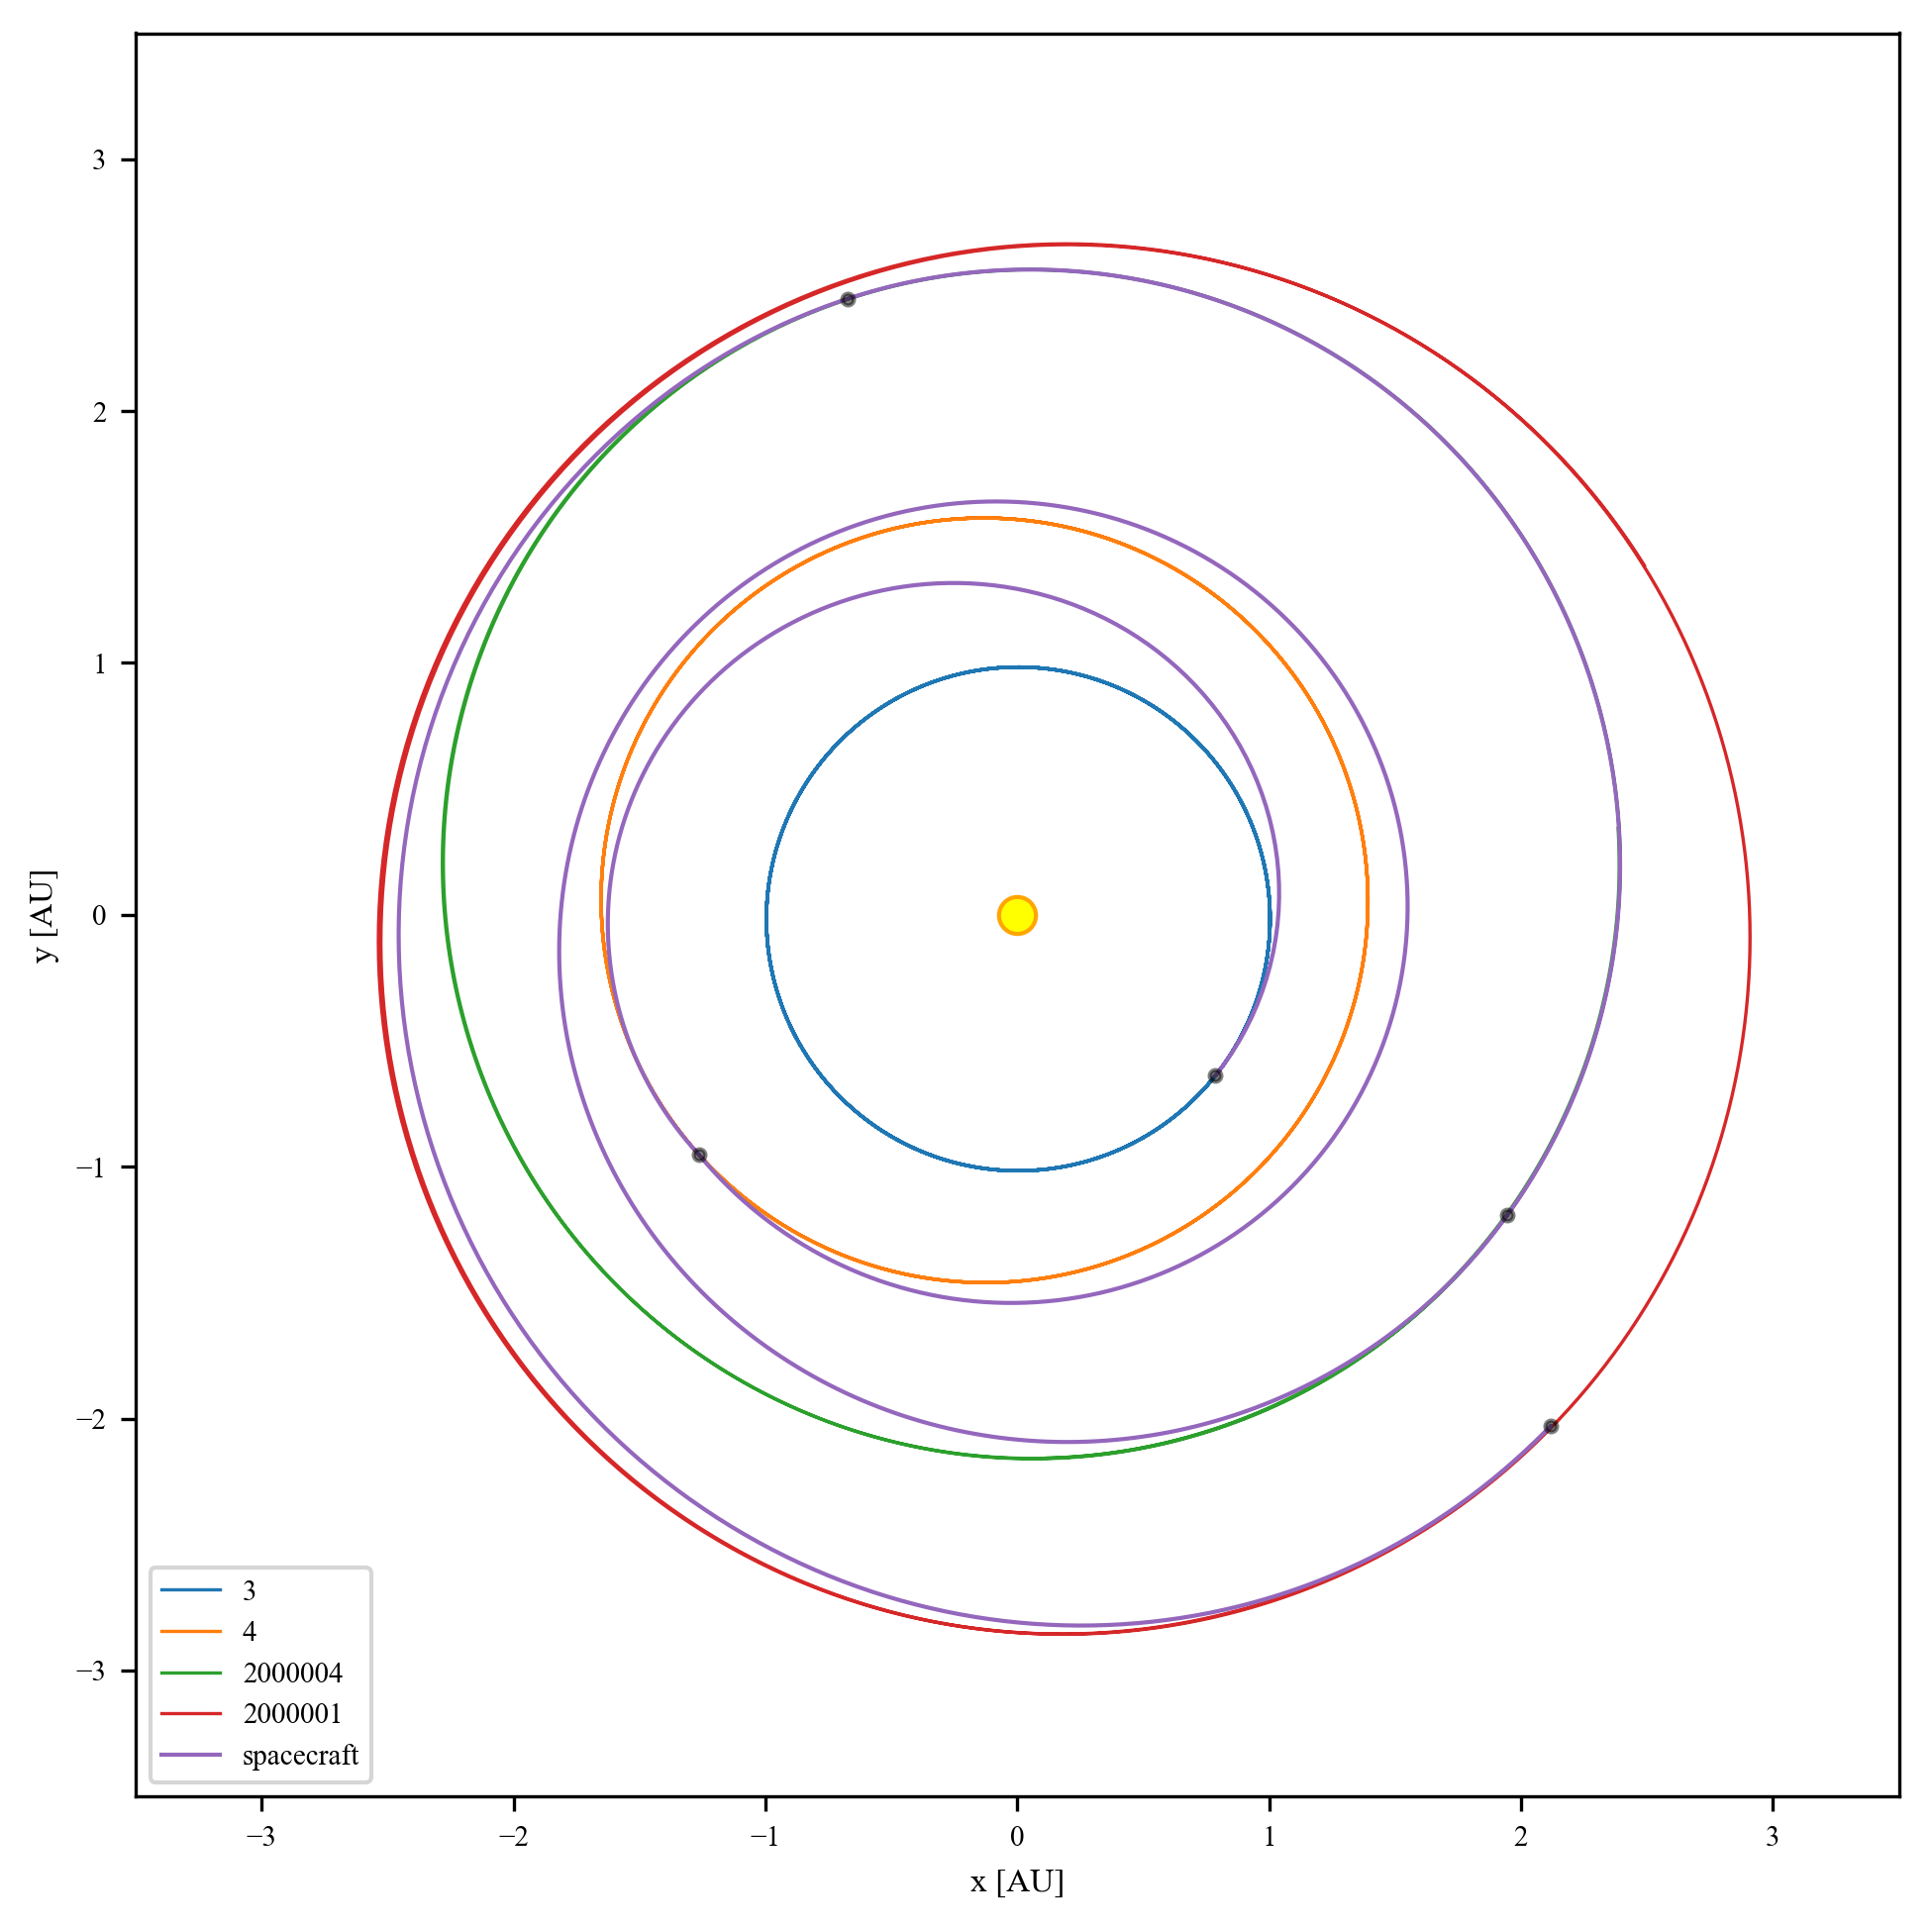

Plot the trajectory in 3D.


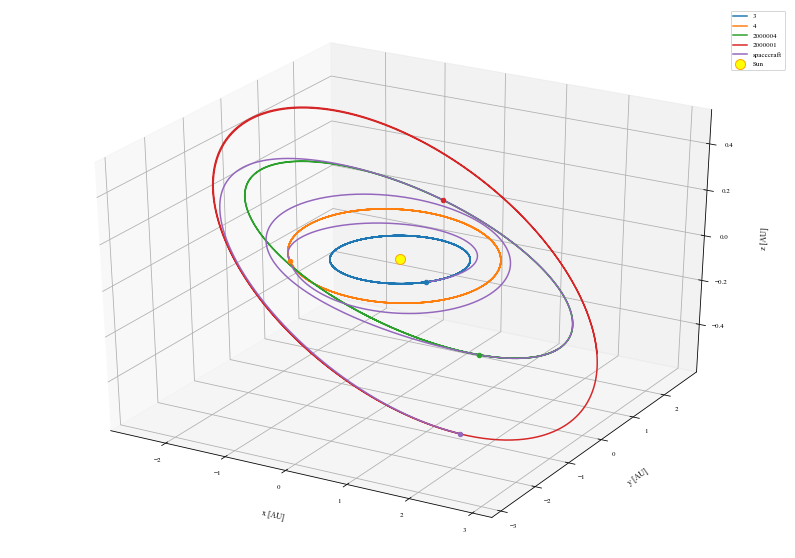

Plot the hodograph.


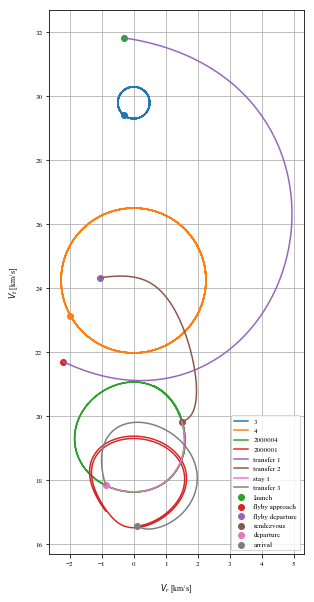

Plot thrust profile.


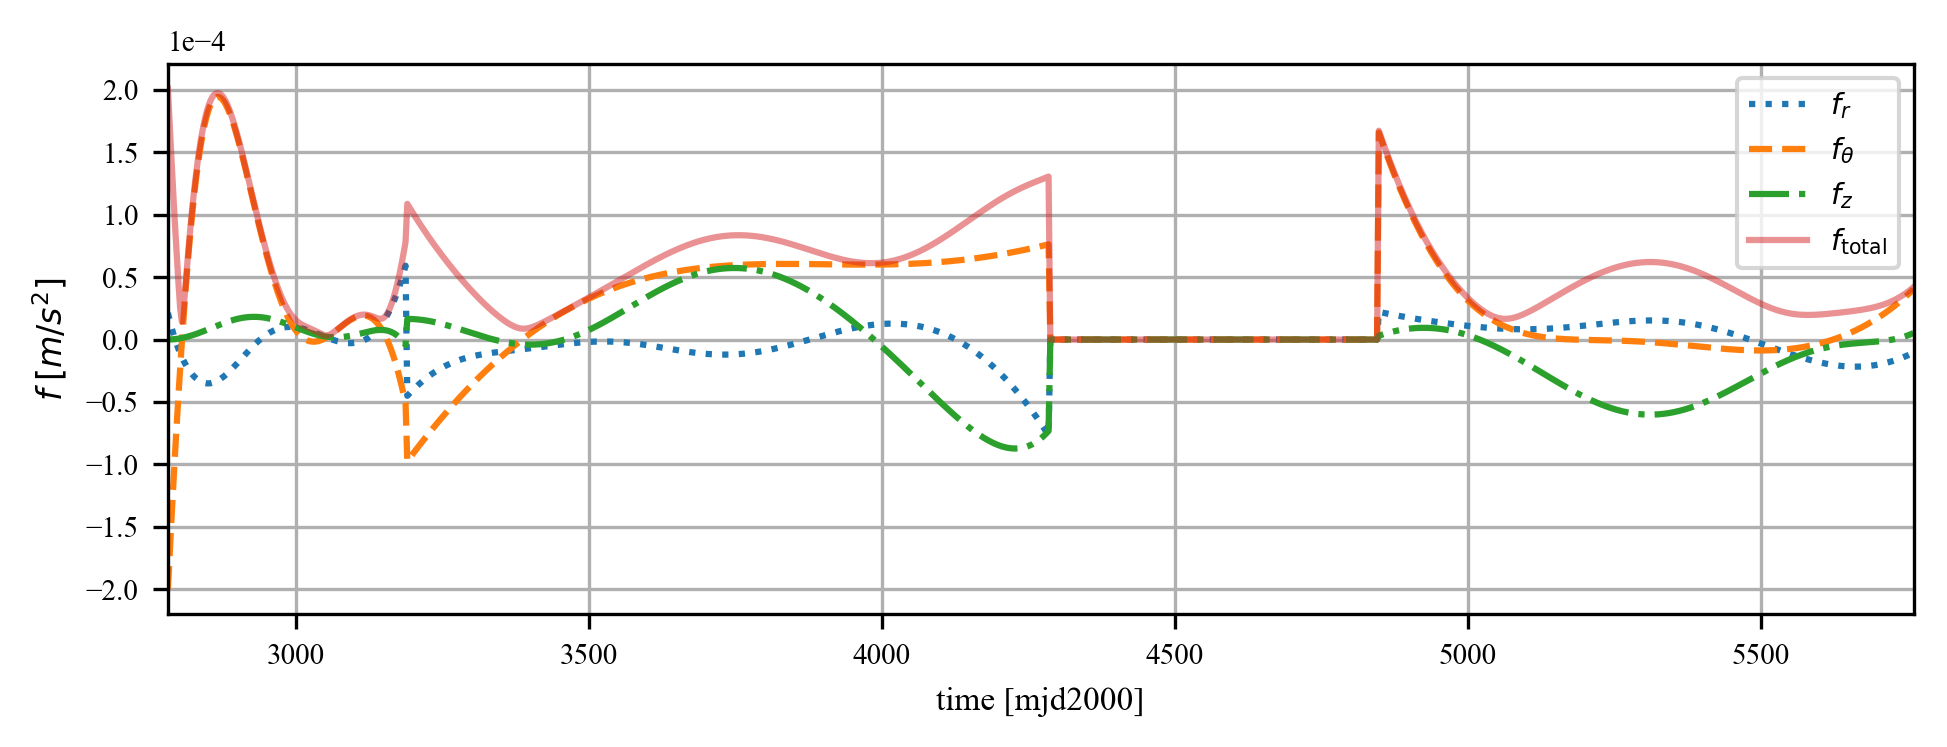

In [7]:
uwuPlots = patchedPlots([transfer, transfer2, transfer3, transfer4],
                           samples=1000,
                           folder=None, save=False, show=True)
uwuPlots.trajectory2D()
uwuPlots.trajectory3D(scaling=False)
uwuPlots.hodograph()
uwuPlots.thrust()

The patchedPlots class also includes animations in 2D and 3D, which unfortunately don't work in an interactive notebook. Please consult the code for this functionality.